In [1]:
import cx_Oracle
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib import rc
rc("font", family = "Malgun Gothic")
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, r2_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import mean_squared_error, mean_squared_log_error 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings("ignore")

In [2]:
db = cx_Oracle.connect("c##lm", "lm", "localhost:1521/xe")
cursor = db.cursor()
cursor.execute("select 고객번호, 거주지역, 선호제휴점포, F14_1, F14_2, F14_3, F14_4, F15_1, F15_2  from PREDICTDATA")
x = cursor.fetchall()

train1 = pd.DataFrame(x)

list1 = ["고객번호","거주지역", "선호제휴점포", "F14_1", "F14_2", "F14_3", "F14_4", "F15_1", "F15_2"]
        
train1.columns = list1

In [3]:
db = cx_Oracle.connect("c##lm", "lm", "localhost:1521/xe")
cursor = db.cursor()
cursor.execute("select 고객번호, 거주지역, 선호제휴점포, F14_2, F14_3, F14_4, F15_1, F15_2, F15_3  from PREDICTDATA")
x = cursor.fetchall()

test1 = pd.DataFrame(x)

list1 = ["고객번호","거주지역", "선호제휴점포", "F14_2", "F14_3", "F14_4", "F15_1", "F15_2", "F15_3"]
        
test1.columns = list1

In [4]:
train2 = pd.read_pickle("dataSet/train1.pkl")
test2 = pd.read_pickle("dataSet/test1.pkl")

In [43]:
train3 = pd.read_pickle("dataSet/train_product.pkl")
test3 = pd.read_pickle("dataSet/test_product.pkl")

,고객번호,최대값1,최대값2,최대값3
0,00001,디지털,가구,의류
1,00002,일상,전문스포츠,신선
2,00003,신선,가공,일상
3,00004,패션잡화,기타,전문스포츠
4,00005,가공,일상,신선
...,...,...,...,...
19378,19379,일상,의약,패션잡화
19379,19380,일상,의약,가공
19380,19381,신선,가공,의약
19381,19382,의약,가공,신선


In [6]:
train1 = train1.sort_values(by='고객번호')
test1 = test1.sort_values(by='고객번호')

In [7]:
train = pd.concat([train1, train2, train3], axis=1)
test = pd.concat([test1, test2, train3], axis=1)

In [8]:
train.drop(["고객번호"], axis = 1, inplace = True)
test.drop(["고객번호"], axis = 1, inplace = True)

In [9]:
train = train.dropna(subset=["F14_1", "F14_2", "F14_3", "F14_4", "F15_1", "F15_2"])
test = test.dropna(subset=["F14_2", "F14_3", "F14_4", "F15_1", "F15_2", "F15_3"])

In [10]:
def get_rank(x):
    cat = ''
    if x < 18997/10 : cat = 1
    elif x < 18997/10 *2 : cat = 2
    elif x < 18997/10 *3: cat = 3
    elif x < 18997/10 *3: cat = 4
    elif x < 18997/10 *4: cat = 5
    elif x < 18997/10 *5: cat = 6
    elif x < 18997/10 *6: cat = 7
    elif x < 18997/10 *7: cat = 8
    elif x < 18997/10 *8: cat = 9   
    else: cat = 10
        
    
    return cat

In [11]:
train['F14_1'] = train['F14_1'].rank(method='max')
train['F14_2'] = train['F14_2'].rank(method='max')
train['F14_3'] = train['F14_3'].rank(method='max')
train['F14_4'] = train['F14_4'].rank(method='max')
train['F15_1'] = train['F15_1'].rank(method='max')
train['F15_2'] = train['F15_2'].rank(method='max')
test['F14_2'] = test['F14_2'].rank(method='max')
test['F14_3'] = test['F14_3'].rank(method='max')
test['F14_4'] = test['F14_4'].rank(method='max')
test['F15_1'] = test['F15_1'].rank(method='max')
test['F15_2'] = test['F15_2'].rank(method='max')
test['F15_3'] = test['F15_3'].rank(method='max')
train['F14_1'] = train['F14_1'].apply(lambda x : get_rank(x))
train['F14_2'] = train['F14_2'].apply(lambda x : get_rank(x))
train['F14_3'] = train['F14_3'].apply(lambda x : get_rank(x))
train['F14_4'] = train['F14_4'].apply(lambda x : get_rank(x))
train['F15_1'] = train['F15_1'].apply(lambda x : get_rank(x))
train['F15_2'] = train['F15_2'].apply(lambda x : get_rank(x))
test['F14_2'] = test['F14_2'].apply(lambda x : get_rank(x))
test['F14_3'] = test['F14_3'].apply(lambda x : get_rank(x))
test['F14_4'] = test['F14_4'].apply(lambda x : get_rank(x))
test['F15_1'] = test['F15_1'].apply(lambda x : get_rank(x))
test['F15_2'] = test['F15_2'].apply(lambda x : get_rank(x))
test['F15_3'] = test['F15_3'].apply(lambda x : get_rank(x))

In [12]:
train = train[train["선호제휴점포"].isin(train["선호제휴점포"].value_counts().index[train["선호제휴점포"].value_counts() > 30])]
test = test[test["선호제휴점포"].isin(test["선호제휴점포"].value_counts().index[test["선호제휴점포"].value_counts() > 30])]

In [13]:
train_ohe = pd.get_dummies(train)
test_ohe = pd.get_dummies(test)

In [14]:
y_train = train_ohe["LABEL"]
y_test = test_ohe["LABEL"]

X_train = train_ohe.drop(["LABEL"], axis = 1)
X_test = test_ohe.drop(["LABEL"], axis = 1)

In [15]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

print(f"accuracy : {accuracy_score(y_test, lr_preds):.4f}")
print(f"precision : {precision_score(y_test, lr_preds):.4f}")
print(f"recall : {recall_score(y_test, lr_preds):.4f}")
print(f"f1 : {f1_score(y_test, lr_preds):.4f}")
print(f"roc_auc : {roc_auc_score(y_test, lr_preds):.4f}")

accuracy : 0.7112
precision : 0.6361
recall : 0.6133
f1 : 0.6245
roc_auc : 0.6938


In [16]:
lgbm = LGBMClassifier()
lgbm.fit(X_train,y_train)
lgbm_preds = lgbm.predict(X_test)

print(f"accuracy : {accuracy_score(y_test, lgbm_preds):.4f}")
print(f"roc_auc : {roc_auc_score(y_test, lgbm_preds):.4f}")

accuracy : 0.7220
roc_auc : 0.7005


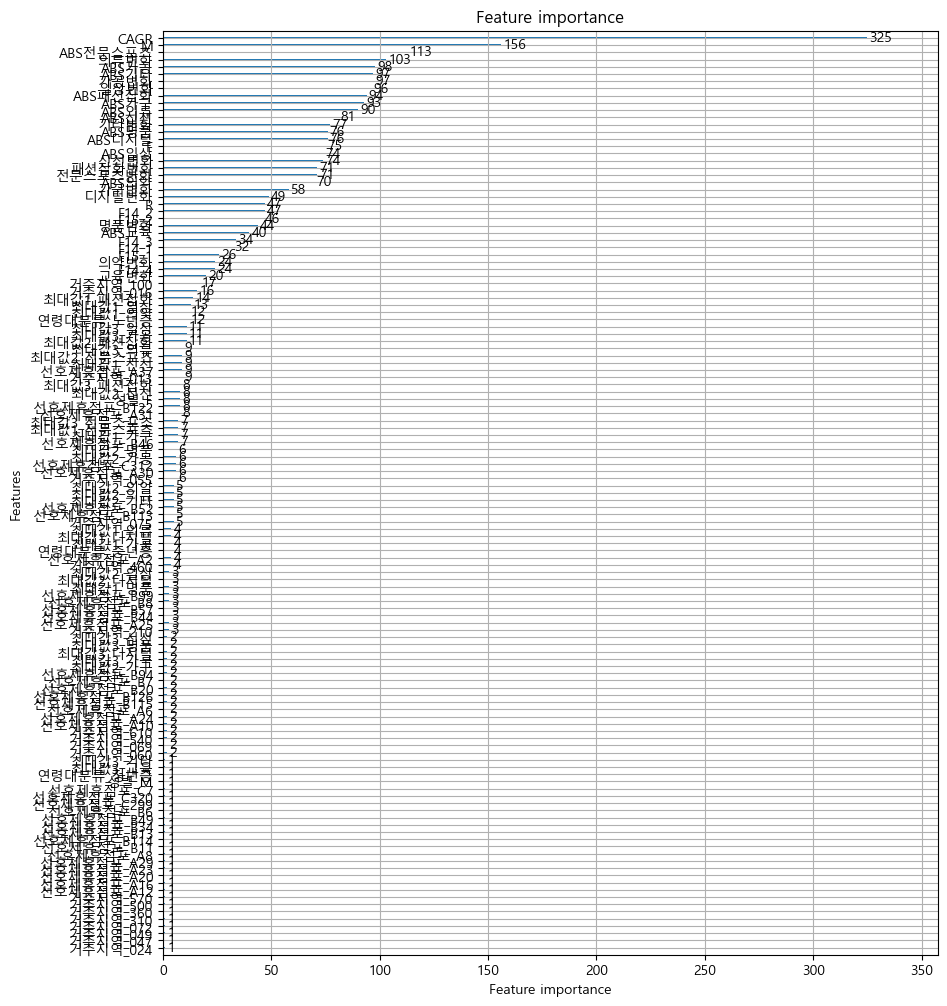

In [17]:
fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(lgbm, ax = ax)
plt.savefig("lightgbm_feature_importance.tif", format = "tif", dpi = 300, bbox_inches = "tight")

In [18]:
train.drop(["연령대분류", "거주지역", "선호제휴점포", "성별"], axis = 1, inplace = True)
test.drop(["연령대분류", "거주지역", "선호제휴점포", "성별"], axis = 1, inplace = True)
train.drop(["F14_1","F14_2", "F14_3", "F14_4", "F15_1", "F15_2"], axis = 1, inplace = True)
test.drop(["F14_2", "F14_3", "F14_4", "F15_1", "F15_2", "F15_3"], axis = 1, inplace = True)

In [19]:
train.drop(["최대값1","최대값2","최대값3"], axis = 1, inplace = True)
test.drop(["최대값1","최대값2","최대값3"], axis = 1, inplace = True)

In [20]:
train_ohe = pd.get_dummies(train)
test_ohe = pd.get_dummies(test)
y_train = train_ohe["LABEL"]
y_test = test_ohe["LABEL"]

X_train = train_ohe.drop(["LABEL"], axis = 1)
X_test = test_ohe.drop(["LABEL"], axis = 1)

lgbm = LGBMClassifier()
lgbm.fit(X_train,y_train)
lgbm_preds = lgbm.predict(X_test)

print(f"accuracy : {accuracy_score(y_test, lgbm_preds):.4f}")
print(f"precision : {precision_score(y_test, lgbm_preds):.4f}")
print(f"recall : {recall_score(y_test, lgbm_preds):.4f}")
print(f"f1 : {f1_score(y_test, lgbm_preds):.4f}")
print(f"roc_auc : {roc_auc_score(y_test, lgbm_preds):.4f}")

accuracy : 0.7236
precision : 0.6613
recall : 0.6027
f1 : 0.6306
roc_auc : 0.7020


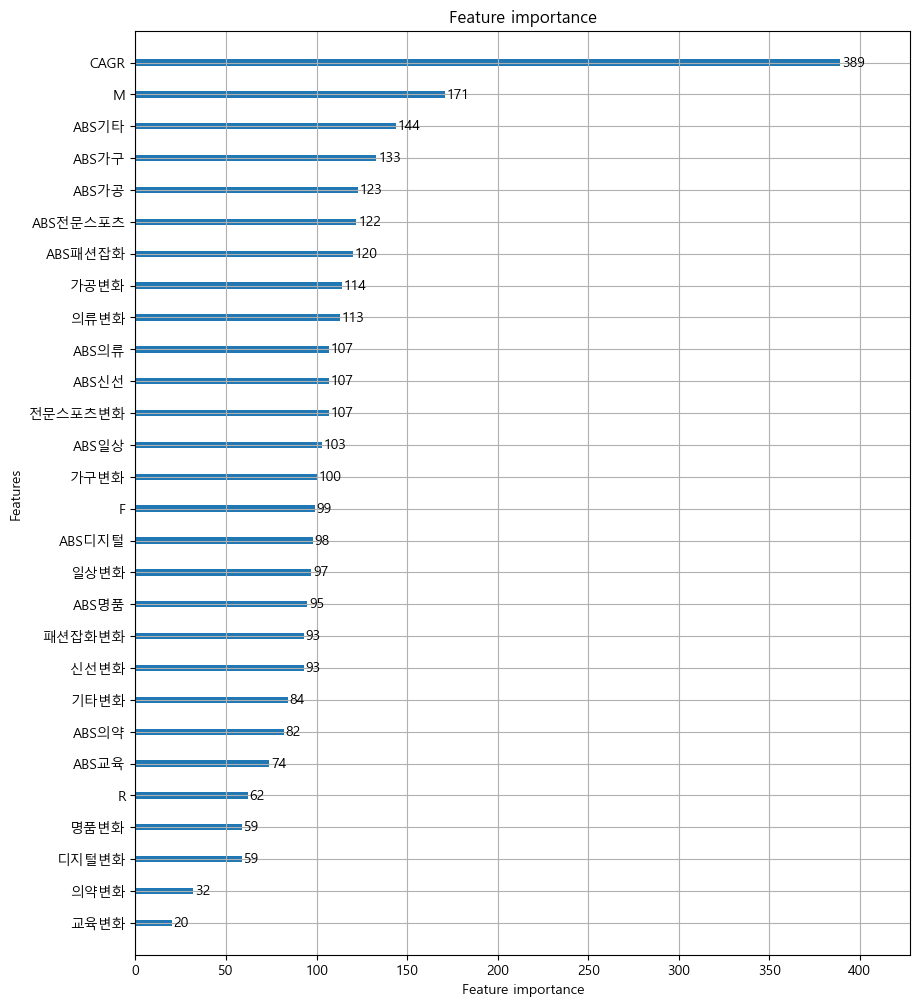

In [21]:
fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(lgbm, ax = ax)
plt.savefig("lightgbm_feature_importance.tif", format = "tif", dpi = 300, bbox_inches = "tight")

In [22]:
# params = {"learning_rate" : [0.001, 0.005, 0.01, 0.05, 0.01, 0.05, 0.1],
#           "n_estimators" : [500, 1000, 1500],
#          "max_depth" : [3, 5, 7, 10]}

# grid = GridSearchCV(lgbm, param_grid=params, cv=3, refit=True)
# grid.fit(X_train, y_train)
# print('GridSearchCV 최적 파라미터:', grid.best_params_)
# print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid.best_score_))

In [23]:
lgbm = LGBMClassifier(learning_rate= 0.01, max_depth= 3, n_estimators= 500)
lgbm.fit(X_train,y_train)
lgbm_preds = lgbm.predict(X_test)

print(f"accuracy : {accuracy_score(y_test, lgbm_preds):.4f}")
print(f"precision : {precision_score(y_test, lgbm_preds):.4f}")
print(f"recall : {recall_score(y_test, lgbm_preds):.4f}")
print(f"f1 : {f1_score(y_test, lgbm_preds):.4f}")
print(f"roc_auc : {roc_auc_score(y_test, lgbm_preds):.4f}")

accuracy : 0.7260
precision : 0.6639
recall : 0.6077
f1 : 0.6346
roc_auc : 0.7049


In [24]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print(f"accuracy : {accuracy_score(y_test, rf_preds):.4f}")
print(f"precision : {precision_score(y_test, rf_preds):.4f}")
print(f"recall : {recall_score(y_test, rf_preds):.4f}")
print(f"f1 : {f1_score(y_test, rf_preds):.4f}")
print(f"roc_auc : {roc_auc_score(y_test, rf_preds):.4f}")

accuracy : 0.7213
precision : 0.6565
recall : 0.6042
f1 : 0.6293
roc_auc : 0.7004


In [25]:
# params = {
#     'n_estimators': [100, 200, 300],  # 트리 개수를 다양하게 설정
#     'max_features': ['sqrt', 'log2'],  # 특성 개수 선택 방법을 다양하게 설정
#     'max_depth': [None, 10, 20],  # 트리의 최대 깊이를 다양하게 설정
#     'min_samples_split': [2, 4, 8],  # 노드 분할을 위한 최소 샘플 수를 다양하게 설정
#     'min_samples_leaf': [1, 2, 4]  # 리프 노드를 형성하기 위한 최소 샘플 수를 다양하게 설정
# }

# grid = GridSearchCV(rf, param_grid=params, cv=3, refit=True)
# grid.fit(X_train, y_train)
# print('GridSearchCV 최적 파라미터:', grid.best_params_)
# print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid.best_score_))

GridSearchCV 최적 파라미터: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 300}


GridSearchCV 최고 정확도: 0.7793

In [26]:
rf = RandomForestClassifier(max_depth = None, max_features = "sqrt", min_samples_leaf = 2, min_samples_split = 4, n_estimators = 300)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print(f"accuracy : {accuracy_score(y_test, rf_preds):.4f}")
print(f"precision : {precision_score(y_test, rf_preds):.4f}")
print(f"recall : {recall_score(y_test, rf_preds):.4f}")
print(f"f1 : {f1_score(y_test, rf_preds):.4f}")
print(f"roc_auc : {roc_auc_score(y_test, rf_preds):.4f}")

accuracy : 0.7251
precision : 0.6607
recall : 0.6124
f1 : 0.6356
roc_auc : 0.7050


In [27]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

print(f"accuracy : {accuracy_score(y_test, lr_preds):.4f}")
print(f"precision : {precision_score(y_test, lr_preds):.4f}")
print(f"recall : {recall_score(y_test, lr_preds):.4f}")
print(f"f1 : {f1_score(y_test, lr_preds):.4f}")
print(f"roc_auc : {roc_auc_score(y_test, lr_preds):.4f}")

accuracy : 0.7135
precision : 0.6368
recall : 0.6241
f1 : 0.6304
roc_auc : 0.6975


In [28]:
# params = {
#     'C': [0.1, 1.0, 10.0],  # 규제 강도를 다양하게 설정
#     'penalty': ['l1', 'l2'],  # 규제 종류를 다양하게 설정
#     'solver': ['lbfgs', 'liblinear', 'saga']  # 최적화 알고리즘을 다양하게 설정
# }

# grid = GridSearchCV(lr, param_grid=params, cv=3, refit=True)
# grid.fit(X_train, y_train)
# print('GridSearchCV 최적 파라미터:', grid.best_params_)
# print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid.best_score_))

GridSearchCV 최적 파라미터: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


GridSearchCV 최고 정확도: 0.7646

In [29]:
lr = LogisticRegression(C = 0.1, penalty = "l1", solver = "liblinear")
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

print(f"accuracy : {accuracy_score(y_test, lr_preds):.4f}")
print(f"precision : {precision_score(y_test, lr_preds):.4f}")
print(f"recall : {recall_score(y_test, lr_preds):.4f}")
print(f"f1 : {f1_score(y_test, lr_preds):.4f}")
print(f"roc_auc : {roc_auc_score(y_test, lr_preds):.4f}")

accuracy : 0.7139
precision : 0.6373
recall : 0.6246
f1 : 0.6309
roc_auc : 0.6980


In [30]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)

print(f"accuracy : {accuracy_score(y_test, dt_preds):.4f}")
print(f"precision : {precision_score(y_test, dt_preds):.4f}")
print(f"recall : {recall_score(y_test, dt_preds):.4f}")
print(f"f1 : {f1_score(y_test, dt_preds):.4f}")
print(f"roc_auc : {roc_auc_score(y_test, dt_preds):.4f}")

accuracy : 0.6615
precision : 0.5671
recall : 0.5721
f1 : 0.5696
roc_auc : 0.6456


In [31]:
# params = {
#     'max_depth': [None, 5, 10, 20],  # 트리의 최대 깊이를 다양하게 설정
#     'min_samples_split': [2, 5, 10],  # 노드 분할을 위한 최소 샘플 수를 다양하게 설정
#     'min_samples_leaf': [1, 2, 4],  # 리프 노드를 형성하기 위한 최소 샘플 수를 다양하게 설정
#     'max_features': ['auto', 'sqrt', 'log2']  # 사용할 특성의 최대 개수를 다양하게 설정
# }

# grid = GridSearchCV(dt, param_grid=params, cv=3, refit=True)
# grid.fit(X_train, y_train)
# print('GridSearchCV 최적 파라미터:', grid.best_params_)
# print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid.best_score_))

In [32]:
dt = DecisionTreeClassifier(max_depth = 5, max_features = "sqrt", min_samples_leaf = 4, min_samples_split = 2)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)

print(f"accuracy : {accuracy_score(y_test, dt_preds):.4f}")
print(f"precision : {precision_score(y_test, dt_preds):.4f}")
print(f"recall : {recall_score(y_test, dt_preds):.4f}")
print(f"f1 : {f1_score(y_test, dt_preds):.4f}")
print(f"roc_auc : {roc_auc_score(y_test, dt_preds):.4f}")

accuracy : 0.6902
precision : 0.6380
recall : 0.4824
f1 : 0.5494
roc_auc : 0.6531


In [33]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

print(f"accuracy : {accuracy_score(y_test, xgb_preds):.4f}")
print(f"precision : {precision_score(y_test, xgb_preds):.4f}")
print(f"recall : {recall_score(y_test, xgb_preds):.4f}")
print(f"f1 : {f1_score(y_test, xgb_preds):.4f}")
print(f"roc_auc : {roc_auc_score(y_test, xgb_preds):.4f}")

accuracy : 0.7173
precision : 0.6517
recall : 0.5971
f1 : 0.6232
roc_auc : 0.6959


In [34]:
# params = {
#     'learning_rate': [0.1, 0.01, 0.001],  # 학습률을 다양하게 설정
#     'max_depth': [3, 5, 7],  # 트리의 최대 깊이를 다양하게 설정
#     'min_child_weight': [1, 3, 5],  # 리프 노드의 최소 가중치 합을 다양하게 설정
#     'subsample': [0.5, 0.7, 0.9],  # 샘플의 비율을 다양하게 설정
#     'colsample_bytree': [0.5, 0.7, 0.9]  # 특성의 비율을 다양하게 설정
# }

# grid = GridSearchCV(xgb, param_grid=params, cv=3, refit=True)
# grid.fit(X_train, y_train)
# print('GridSearchCV 최적 파라미터:', grid.best_params_)
# print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid.best_score_))

In [35]:
xgb = XGBClassifier(colsample_bytree = 0.9, learning_rate = 0.01, max_depth = 5, min_child_weight = 1, subsample = 0.5)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

print(f"accuracy : {accuracy_score(y_test, xgb_preds):.4f}")
print(f"precision : {precision_score(y_test, xgb_preds):.4f}")
print(f"recall : {recall_score(y_test, xgb_preds):.4f}")
print(f"f1 : {f1_score(y_test, xgb_preds):.4f}")
print(f"roc_auc : {roc_auc_score(y_test, xgb_preds):.4f}")

accuracy : 0.7256
precision : 0.6669
recall : 0.5976
f1 : 0.6304
roc_auc : 0.7028


In [36]:
predictdata = pd.read_pickle("dataSet/train2.pkl")
predictdata.drop(["성별","연령대분류"], axis = 1, inplace = True)
predictdata

,가공변화,신선변화,일상변화,의약변화,교육변화,디지털변화,가구변화,의류변화,전문스포츠변화,패션잡화변화,...,ABS가구,ABS의류,ABS전문스포츠,ABS패션잡화,ABS명품,ABS기타,R,F,M,CAGR
0,-6,0,-1,0,0,-7,0,-1,6,0,...,20,1,12,18,24,2,4,4,1,-10.91
1,0,0,0,0,0,-9,0,0,-1,-2,...,34,4,5,8,18,25,4,4,1,-11.55
2,-2,-3,0,0,0,-8,0,0,0,3,...,0,0,0,3,0,4,3,5,10,-6.03
3,3,2,-5,0,0,0,-8,-2,-8,-2,...,26,4,12,12,16,29,8,3,6,-9.79
4,2,-1,-1,0,0,0,-9,1,-6,-2,...,9,23,6,8,0,0,3,2,7,8.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19378,1,0,5,9,0,0,0,5,0,5,...,0,11,0,21,8,12,2,1,10,9.32
19379,2,0,9,7,0,8,0,0,0,0,...,0,0,0,8,0,3,6,1,10,10.33
19380,6,7,5,7,0,0,6,0,0,3,...,10,12,10,7,0,8,6,3,10,9.49
19381,7,6,1,8,0,0,6,2,0,4,...,18,10,12,12,0,5,6,3,10,9.40


In [37]:
predictdata.columns

Index(['가공변화', '신선변화', '일상변화', '의약변화', '교육변화', '디지털변화', '가구변화', '의류변화',
       '전문스포츠변화', '패션잡화변화', '명품변화', '기타변화', 'ABS가공', 'ABS신선', 'ABS일상', 'ABS의약',
       'ABS교육', 'ABS디지털', 'ABS가구', 'ABS의류', 'ABS전문스포츠', 'ABS패션잡화', 'ABS명품',
       'ABS기타', 'R', 'F', 'M', 'CAGR'],
      dtype='object')

In [38]:
preds = lgbm.predict(predictdata)
preds

array([1, 1, 0, ..., 0, 0, 0], dtype=int64)

In [39]:
predictdata["LABEL"] = preds

In [40]:
predictdata["LABEL"].value_counts()

0    12463
1     6920
Name: LABEL, dtype: int64

In [41]:
customerdata = pd.read_pickle("dataSet/customerdata.pkl")
customerdata["LABEL"] = preds

In [42]:
customerdata[["LABEL","구매 총액"]].groupby("LABEL").sum()

,구매 총액
LABEL,
0,432130941344
1,244888215597
